In [1]:
%run part01_data_preparation.ipynb

<class 'pandas.core.frame.DataFrame'>
Int64Index: 141736 entries, 0 to 141946
Data columns (total 36 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   hotel                           141736 non-null  object        
 1   is_canceled                     141736 non-null  int64         
 2   lead_time                       141736 non-null  int64         
 3   arrival_date_year               141736 non-null  int64         
 4   arrival_date_month              141736 non-null  object        
 5   arrival_date_week_number        141736 non-null  int64         
 6   arrival_date_day_of_month       141736 non-null  int64         
 7   stays_in_weekend_nights         141736 non-null  int64         
 8   stays_in_week_nights            141736 non-null  int64         
 9   adults                          141736 non-null  int64         
 10  children                        141736 non-null  int32  

# Data Preparation

In [2]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from scipy.stats import norm
import time

### Machine Learning Libraries ###
from sklearn.model_selection import train_test_split, cross_val_predict, GridSearchCV, KFold, cross_validate, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler, OneHotEncoder, MinMaxScaler, OrdinalEncoder, FunctionTransformer 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.compose import ColumnTransformer
from sklearn.metrics import make_scorer, accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, auc, classification_report, plot_confusion_matrix
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2, f_classif, SelectFromModel, VarianceThreshold, SelectPercentile
from sklearn import set_config
from sklearn.impute import SimpleImputer
from sklearn.base import TransformerMixin

import sys

import joblib

sys.path.append("..")

In [3]:
data_prep = data.copy()
len(data_prep.columns)

36

In [4]:
data_prep.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date', 'adr_pp', 'people',
       'kids', 'days_stay'],
      dtype='object')

## Feature Engieenier

In [5]:
data_prep["country"] = [0 if i =='PRT' else 1 for i in data_prep["country"]] # native or foreigner
data_prep["previous_cancellations"] = [0 if i == 0 else 1 for i in data_prep["previous_cancellations"]] # not cancel once or cancel at least once
data_prep["company"] = [0 if i == 0 else 1 for i in data_prep["company"]] # do not have a Company or have a Company

meal_dct = {'Undefined':0,'BB':1,'HB':2,'FB':3,'SC':4}
data_prep["meal"] = [meal_dct[m] for m in data_prep["meal"]]

In [6]:
data_prep.meal.value_counts(normalize=True)

1    0.774602
2    0.129784
4    0.086950
3    0.008664
Name: meal, dtype: float64

In [7]:
drop_numerical_features = ['is_canceled', # Target Feature
                           'arrival_date_year', 
                           'stays_in_weekend_nights','stays_in_week_nights', # Replaced by days_stay
                           'children', 'babies', # Replaced by kids
                           'previous_bookings_not_canceled',
                           'days_in_waiting_list', # low variance 
                           'adr_pp', # almost same meaning of adr
                           'previous_bookings_not_canceled',
                           'people'] # Same meaning of Adults + Kids 

numerical_df = data_prep.select_dtypes(include = ["number"]).drop(drop_numerical_features, axis=1)
numerical_features =  data_prep.select_dtypes(include=["number"]).drop(drop_numerical_features, axis=1).columns
numerical_list = numerical_features.tolist()

In [8]:
drop_categorical_features = ['arrival_date_month', # almost same meaning of arrival_date_week_number
                             'distribution_channel', # almost same meaning of market_segment
                             'deposit_type', # not predtive
                             'reservation_status', # not predtive
                             'reservation_status_date', # not predtive
                             'assigned_room_type'] # Almost always same of reserved_room_type

categorical_df = data_prep.select_dtypes(include = ['category','object','datetime']).drop(drop_categorical_features, axis=1)
categorical_features = data_prep.select_dtypes(include=["category","object","datetime"]).drop(drop_categorical_features, axis=1).columns
categorical_list=categorical_features.tolist()

## Normalization

In [9]:
#sns.pairplot(numerical_df, aspect=1.5);

In [10]:
log_columns = data_prep[numerical_list].skew().sort_values(ascending=False)
log_columns = log_columns.loc[(log_columns > 0.75)]
log_columns

adults                         24.749257
adr                             9.528857
booking_changes                 5.522578
is_repeated_guest               5.416710
kids                            4.420196
required_car_parking_spaces     4.100500
company                         3.818756
days_stay                       3.198430
previous_cancellations          3.173181
meal                            2.209273
total_of_special_requests       1.394436
lead_time                       1.317312
agent                           1.282939
dtype: float64

In [11]:
for col in log_columns.index:
    numerical_df[col] = np.log1p(numerical_df[col])

## Encoding

In [12]:
categorical_df=pd.get_dummies(data_prep[categorical_list])#,drop_first=True

In [13]:
categorical_df

,hotel_City Hotel,hotel_Resort Hotel,market_segment_Aviation,market_segment_Complementary,market_segment_Corporate,market_segment_Direct,market_segment_Groups,market_segment_Offline TA/TO,market_segment_Online TA,market_segment_Undefined,...,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,reserved_room_type_H,reserved_room_type_L,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
0,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
1,0,1,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,1,0
2,0,1,0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,1,0
3,0,1,0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,1,0
4,0,1,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141942,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
141943,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
141944,1,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
141945,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [14]:
X = pd.concat([numerical_df,categorical_df], axis=1)

In [15]:
target = 'is_canceled'
selected_features = numerical_list + categorical_list

X = data_prep[selected_features]
y = data_prep[target]

len(selected_features)

20

In [16]:
selected_features

['lead_time',
 'arrival_date_week_number',
 'arrival_date_day_of_month',
 'adults',
 'meal',
 'country',
 'is_repeated_guest',
 'previous_cancellations',
 'booking_changes',
 'agent',
 'company',
 'adr',
 'required_car_parking_spaces',
 'total_of_special_requests',
 'kids',
 'days_stay',
 'hotel',
 'market_segment',
 'reserved_room_type',
 'customer_type']

# Machine Learning Model

## Pipeline

Below are some things I need to review in the code:

- Find a way to normalize certain features inside the pipeline<br>
- Find a way to put diferent enconders inside pipeline like onehotencoder, ordinal encoder, manualy enconders<br>
- Find a way to put functions inside the pipeline to do the operations above<br>

In [87]:
ohe_list = ['hotel','arrival_date_month','country', 'market_segment',
            'distribution_channel','reserved_room_type','deposit_type','customer_type']
ore_list = ['meal']

selection = SelectPercentile(f_classif, percentile=80)
#num_selection = SelectPercentile(f_classif, percentile=80)
#cat_selection = SelectPercentile(chi2, percentile=80)

numerical_transformer = Pipeline(steps=[("imputer", SimpleImputer(strategy="median", fill_value="Unknown")),
                                        #("norm", apply_log(X)),
                                        ("std", RobustScaler()),
                                       # ("selection", SelectPercentile(f_classif, percentile=80))
                                       ])


categorical_transformer = Pipeline(steps=[("imputer", SimpleImputer(strategy="constant", fill_value="Unknown")),
                                          ("ohe", OneHotEncoder(handle_unknown="ignore", drop="if_binary")),
                                         # ("selection", SelectPercentile(chi2, percentile=80))                                          
                                         ])      


preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

In [88]:


lr = LogisticRegression()
rf = RandomForestClassifier()
xgb = XGBClassifier()

pipeline_lr = Pipeline(
    steps=[("preprocessor", preprocessor), 
           ('selection', selection),
           ("classifier", lr)]
) 
    
pipeline_rf = Pipeline(
    steps=[("preprocessor", preprocessor),            
           ('selection', selection),
           ("classifier", rf)]
) 

pipeline_xgb = Pipeline(
    steps=[("preprocessor", preprocessor),
           ('selection', selection),
           ("classifier", xgb)]
) 

In [89]:
pipelines = [pipeline_lr,pipeline_xgb, pipeline_rf]
pipe_dict = {0:'Logistic Regression', 1:'XGBoost', 2:'Random Forest'} #2:'Random Forest'

In [90]:
pipeline_lr

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='Unknown',
                                                                                 strategy='median')),
                                                                  ('std',
                                                                   RobustScaler())]),
                                                  Index(['lead_time', 'arrival_date_week_number', 'arrival_date_day_of_month',
       'adults', 'meal', 'country', 'is_repeated_guest',
       'previous_cancellations', 'booking_changes', 'agent', '...
       'days_stay'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='Unknown',
                                                                                 strategy='constant')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore'))]),
                                                  Index(['hotel', 'market_segment', 'reserved_room_type', 'customer_type'], dtype='object'))])),
                ('selection', SelectPercentile(percentile=80)),
                ('classifier', LogisticRegression())])

## Train-Test Split

In [75]:
seed=7
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3, stratify=y, random_state=seed)
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((99215, 20), (99215,), (42521, 20), (42521,))

In [76]:
def CM(y, y_pred):
    print("Confusion Matrix:")
    labels = ["Non-canceled", "Canceled"]
    cm = confusion_matrix(y, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format="d")  
    plt.show() 
    print("Metrics \n", classification_report(y,y_pred))   

In [22]:
model = pipeline_xgb.fit(X_train, y_train)
predictions = model.predict(X_val)
acc = accuracy_score(y_val, predictions)

print("acc:", acc)

acc: 0.8834458267679499


In [23]:
model = pipeline_lr.fit(X_train, y_train)
predictions = model.predict(X_val)
acc = accuracy_score(y_val, predictions)

print("acc:", acc)

acc: 0.8016979845252934


## Cross Validation

In [46]:
def CVS(model, X, y, model_dict=''):    
    
    number_folds = 3
    #Kfold = KFold(n_splits=number_folds, shuffle=True, random_state=seed)
    Kfold = StratifiedKFold(n_splits=number_folds, shuffle=True, random_state=seed)
    
    scoring = {'Accuracy': make_scorer(accuracy_score),
               'Precision': make_scorer(precision_score),
               'f1': make_scorer(f1_score),
               'Recall': make_scorer(recall_score)}    
    
    validation_score = pd.DataFrame(columns=['Method','Time','Accuracy','Precision','Recall','F1 Score'])

    y_pred = cross_val_predict(model, X, y, cv=Kfold, method='predict')
   
    CM(y,y_pred)
   
    scores = cross_validate(model, X, y, cv = Kfold, scoring=scoring)
    
    for chave, valor in scores.items():
        print(f"{chave}, over {number_folds} folds attempts: {round(np.mean(valor),5)} +/- {round(np.std(valor),5)}")      
  
    print("\n")
    n=25
    print(f"First {n} Predictions: {y_pred[0:n]}\nLast {n} Predictions: {y_pred[n:0:-1]} \n")   
    
    validation_score = (model_dict, 
                        (scores.get('fit_time').mean()+scores.get('score_time').mean()),
                        scores.get('test_Accuracy').mean(), 
                        scores.get('test_Precision').mean(),
                        scores.get('test_f1').mean(), 
                        scores.get('test_Recall').mean())  

    return y_pred, validation_score

*****************************************************
Machine Learning algorithm: Logistic Regression
*****************************************************
Confusion Matrix:


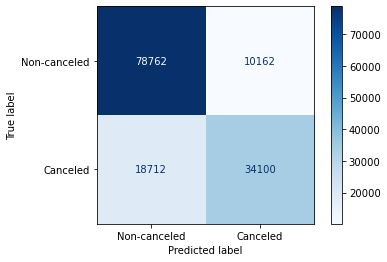

Metrics 
               precision    recall  f1-score   support

           0       0.81      0.89      0.85     88924
           1       0.77      0.65      0.70     52812

    accuracy                           0.80    141736
   macro avg       0.79      0.77      0.77    141736
weighted avg       0.79      0.80      0.79    141736

fit_time, over 3 folds attempts: 0.97207 +/- 0.02007
score_time, over 3 folds attempts: 0.12913 +/- 0.00571
test_Accuracy, over 3 folds attempts: 0.79628 +/- 0.00096
test_Precision, over 3 folds attempts: 0.77045 +/- 0.00345
test_f1, over 3 folds attempts: 0.70254 +/- 0.00255
test_Recall, over 3 folds attempts: 0.64569 +/- 0.00598


First 25 Predictions: [1 1 1 0 0 1 1 1 1 1 0 0 0 1 1 1 1 1 0 0 1 1 1 1 0]
Last 25 Predictions: [1 0 1 1 1 1 0 0 1 1 1 1 1 0 0 0 1 1 1 1 1 0 0 1 1] 

*****************************************************
Machine Learning algorithm: XGBoost
*****************************************************
Confusion Matrix:


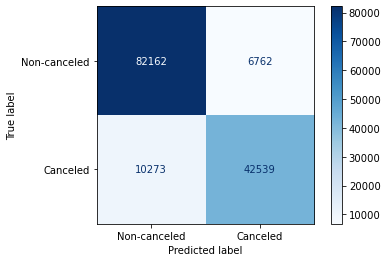

Metrics 
               precision    recall  f1-score   support

           0       0.89      0.92      0.91     88924
           1       0.86      0.81      0.83     52812

    accuracy                           0.88    141736
   macro avg       0.88      0.86      0.87    141736
weighted avg       0.88      0.88      0.88    141736

fit_time, over 3 folds attempts: 2.35926 +/- 0.14751
score_time, over 3 folds attempts: 0.20775 +/- 0.00281
test_Accuracy, over 3 folds attempts: 0.87981 +/- 0.00201
test_Precision, over 3 folds attempts: 0.86285 +/- 0.0027
test_f1, over 3 folds attempts: 0.83317 +/- 0.0031
test_Recall, over 3 folds attempts: 0.80548 +/- 0.00512


First 25 Predictions: [1 0 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 0]
Last 25 Predictions: [1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 0] 

*****************************************************
Machine Learning algorithm: Random Forest
*****************************************************
Confusion Matrix:


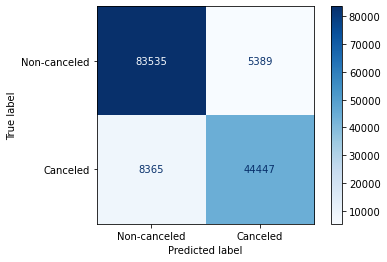

Metrics 
               precision    recall  f1-score   support

           0       0.91      0.94      0.92     88924
           1       0.89      0.84      0.87     52812

    accuracy                           0.90    141736
   macro avg       0.90      0.89      0.89    141736
weighted avg       0.90      0.90      0.90    141736

fit_time, over 3 folds attempts: 8.59557 +/- 0.35051
score_time, over 3 folds attempts: 0.84352 +/- 0.09368
test_Accuracy, over 3 folds attempts: 0.90345 +/- 0.00188
test_Precision, over 3 folds attempts: 0.89274 +/- 0.00186
test_f1, over 3 folds attempts: 0.86666 +/- 0.00285
test_Recall, over 3 folds attempts: 0.84206 +/- 0.00468


First 25 Predictions: [1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0]
Last 25 Predictions: [1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0] 

Wall time: 1min 16s


In [28]:
%%time

validation_score = pd.DataFrame(columns=['Method','Time','Accuracy','Precision','Recall','F1 Score'])

for i,model in enumerate(pipelines): 
    print('*' * 53) 
    print(f"Machine Learning algorithm: {pipe_dict[i]}") 
    print('*' * 53)     
    y_pred , validation_score.loc[i]  = CVS(model,X,y,pipe_dict[i])   

In [29]:
validation_score

,Method,Time,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,1.101200,0.796283,0.770454,0.702544,0.645687
1,XGBoost,2.567006,0.879812,0.862850,0.833169,0.805480
2,Random Forest,9.439090,0.903454,0.892742,0.866656,0.842062


## ROC and AUC

*****************************************************
Machine Learning algorithm: Logistic Regression
*****************************************************


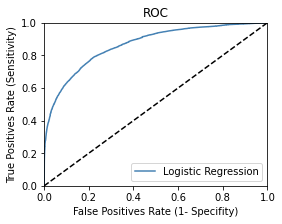

AUC Logistic Regression: 0.8656


*****************************************************
Machine Learning algorithm: XGBoost
*****************************************************


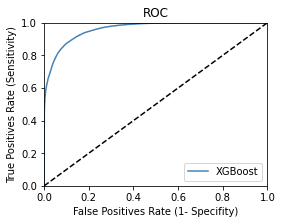

AUC XGBoost: 0.9615


*****************************************************
Machine Learning algorithm: Random Forest
*****************************************************


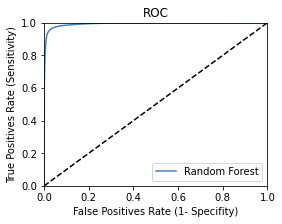

AUC Random Forest: 0.9935




In [27]:
score_metrics_auc = pd.DataFrame(columns=['Model','AUC'])

for i,model in enumerate(pipelines): 
    print('*' * 53) 
    print(f"Machine Learning algorithm: {pipe_dict[i]}") 
    print('*' * 53)   
    y_prob = model.fit(X_train,y_train)
    y_prob = model.predict_proba(X)
    y_prob = y_prob[:,1]
    
    fpr,tpr, threshold = roc_curve(y,y_prob)
    auc = roc_auc_score(y,y_prob)
    plt.figure(figsize=(4, 3))
    plt.plot(fpr,tpr, color='steelblue', label = pipe_dict[i])    
    plt.title("ROC")
    plt.xlim(0.0, 1.0)
    plt.ylim(0.0, 1.0)
    plt.plot([0,1],[0,1], color='black', linestyle='--')
    plt.xlabel("False Positives Rate (1- Specifity)")
    plt.ylabel("True Positives Rate (Sensitivity)")
    plt.legend(loc = 'lower right') 
    plt.show()
    print(f"AUC {pipe_dict[i]}: {auc:.4f}\n\n") 
    
    score_metrics_auc.loc[i]=[pipe_dict[i], auc]

In [26]:
validation_score['AUC'] = score_metrics_auc['AUC']
validation_score

,Method,Time,Accuracy,Precision,Recall,F1 Score,AUC
0,Logistic Regression,0.890870,0.791394,0.791451,0.681016,0.597629,0.863034
1,XGBoost,1.690308,0.867952,0.855146,0.814349,0.777285,0.949157
2,Random Forest,5.497292,0.868678,0.835082,0.820762,0.806938,0.974824


## Feature Selection

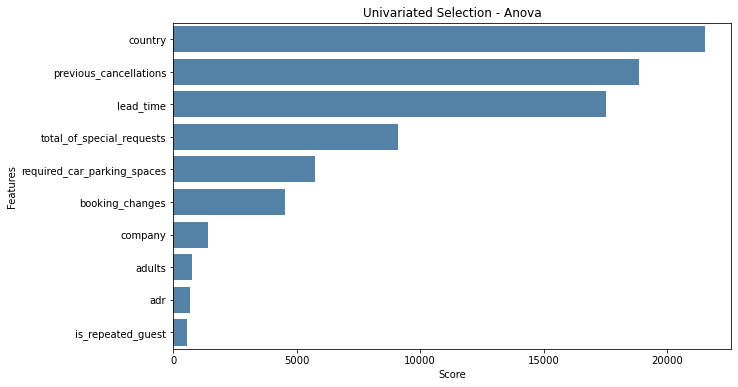

In [83]:
### Apply SelectKBest Algorithm - Anova
anova = SelectKBest(score_func=f_classif, k=10).fit(numerical_df,y)
anova_scores=pd.DataFrame(anova.scores_,columns=["Score"])
anova_columns=pd.DataFrame(numerical_df.columns)
anova_feature_rank=pd.concat([anova_columns,anova_scores],axis=1)
anova_feature_rank.columns=['Features','Score']
anova_feature_rank=anova_feature_rank.nlargest(10,'Score')

plt.figure(figsize=(10,6))
plt.title('Univariated Selection - Anova')
sns.barplot(data=anova_feature_rank, x='Score', y='Features', color='SteelBlue');
plt.show()

In [31]:
categorical_df_dummy = pd.get_dummies(categorical_df)

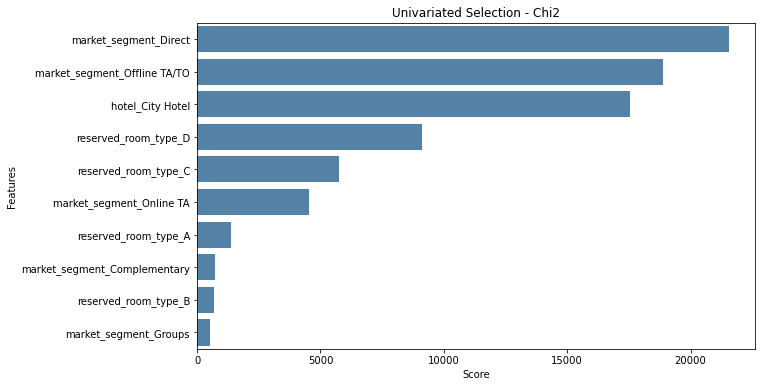

In [32]:
### Apply SelectKBest Algorithm - Chi2
chi2 = SelectKBest(score_func=chi2, k=10).fit(categorical_df_dummy,y)
chi2_scores=pd.DataFrame(chi2.scores_,columns=["Score"])
chi2_columns=pd.DataFrame(categorical_df_dummy.columns)
chi2_feature_rank=pd.concat([chi2_columns,anova_scores],axis=1)
chi2_feature_rank.columns=['Features','Score']
chi2_feature_rank=chi2_feature_rank.nlargest(10,'Score')

plt.figure(figsize=(10,6))
plt.title('Univariated Selection - Chi2')
sns.barplot(data=chi2_feature_rank, x='Score', y='Features', color='SteelBlue');
plt.show()

In [33]:
data.is_canceled.loc[(data['market_segment']=='Online TA')].value_counts(normalize=True)

0    0.640644
1    0.359356
Name: is_canceled, dtype: float64

In [34]:
data.is_canceled.value_counts(normalize=True)

0    0.627392
1    0.372608
Name: is_canceled, dtype: float64

## Hyperparameter Tunning

In [36]:
# tunning_time = factor*((fit_time+score_time)*cv*n_iter)/3600
# tunning_time

NameError: name 'factor' is not defined

### Hyperparameter Tunning - Logist Regression

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Confusion Matrix:


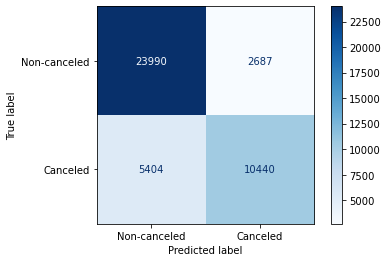

Metrics 
               precision    recall  f1-score   support

           0       0.82      0.90      0.86     26677
           1       0.80      0.66      0.72     15844

    accuracy                           0.81     42521
   macro avg       0.81      0.78      0.79     42521
weighted avg       0.81      0.81      0.81     42521


Accuracy Score Traning:0.8054125069887825, Accuracy Score Validation:0.8097175513275793

Best Paramters:
{'classifier__C': 10, 'classifier__penalty': 'l1', 'classifier__solver': 'saga', 'preprocessor__num__std': MinMaxScaler()}

Best Estimator:
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='Unknown',
                                                                                 strategy='median')),
                                            

In [91]:
%%time
### Tunning parameters: Logistic Regression ###

np.random.seed(7)

params_lr = { 
        'preprocessor__num__std' : [MinMaxScaler(), RobustScaler()],
        #'selection': [SelectPercentile(f_classif, percentile=80)],
       # 'preprocessor__cat__selection': [SelectPercentile(chi2, percentile=80)],
        'classifier__C': [0.1,1,10], 
        'classifier__solver': ['lbfgs','saga'], 
        'classifier__penalty': ['l1','l2'],
        
}

gs = GridSearchCV(estimator=pipeline_lr, param_grid=params_lr, cv=3, scoring="accuracy", verbose=True, return_train_score=False)
gs.fit(X_train,y_train)


lr_tuned_best_score = gs.best_score_
lr_tuned_best_params = gs.best_params_
lr_tuned_best_estimator = gs.best_estimator_
y_pred_lr_tuned = gs.best_estimator_.predict(X_val)
validation_score = gs.score(X_val, y_val)

CM(y_val, y_pred_lr_tuned)

print(f"\nAccuracy Score Traning:{gs.best_score_}, Accuracy Score Validation:{validation_score}")
print(f"\nBest Paramters:\n{gs.best_params_}")
print(f"\nBest Estimator:\n{gs.best_estimator_}")

### Hyperparameter Tunning - Random Forest

In [ ]:
np.random.seed(7)

params_rf  = {'criterion': ['entropy', 'gini'],
               'max_depth': [12,18,24,30],
               'max_features': ['auto', 'sqrt'],
               'min_samples_leaf': [1, 4, 6, 8],
               'min_samples_split': [5, 7,10],
               'n_estimators': [100,500,1000]}


gs = GridSearchCV(estimator=pipeline_rf, param_grid=params, cv=3, scoring="accuracy", n_jobs=2, verbose=True, return_train_score=False)
gs.fit(X_train,y_train)


rf_tuned_best_score = gs.best_score_
rf_tuned_best_params = gs.best_params_
rf_tuned_best_estimator = gs.best_estimator_
y_pred_rf_tuned = gs.best_estimator_.predict(X_val)
validation_score = gs.score(X_val, y_val)

CM(y_val, y_pred_xgb_tuned)

print(f"\nAccuracy Score Traning:{gs.best_score_}, Accuracy Score Validation:{validation_score}") 
print(f"\nBest Paramters:\n{gs.best_params_}") 
print(f"\nBest Estimator:\n{gs.best_estimator_}") 

### Hyperparameter Tunning - XGBoost

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Confusion Matrix:


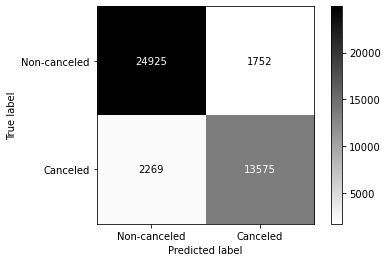

Metrics 
               precision    recall  f1-score   support

           0       0.92      0.93      0.93     26677
           1       0.89      0.86      0.87     15844

    accuracy                           0.91     42521
   macro avg       0.90      0.90      0.90     42521
weighted avg       0.91      0.91      0.91     42521


Accuracy Score Traning:0.8951771376875342, Accuracy Score Validation:0.9054349615484114

Best Paramters:
{'classifier__learning_rate': 0.05, 'classifier__max_depth': 18, 'classifier__n_estimators': 500, 'preprocessor__num__std': MinMaxScaler(), 'selection': SelectPercentile(percentile=95)}

Best Estimator:
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='Unknown',
                                                                                 st

In [42]:
%%time
### Tunning parameters: XGBoost

np.random.seed(7)

params_xgb = { 
        #'preprocessor__num__std' : [MinMaxScaler(), RobustScaler()],
        'selection': [SelectPercentile(f_classif, percentile=80)],
        'classifier__max_depth': [18,24,30],
        'classifier__learning_rate': [0.05,0.10], 
        #'classifier__min_child_weight': [1,3],
        'classifier__n_estimators': [100, 300, 600],    
        #'classifier__eta' : [0.1, 0.3]
            }

gs = GridSearchCV(estimator=pipeline_xgb, param_grid=params_xgb, cv=3, scoring="accuracy", n_jobs=2, verbose=True, return_train_score=False)
gs.fit(X_train,y_train)


xgb_tuned_best_score = gs.best_score_
xgb_tuned_best_params = gs.best_params_
xgb_tuned_best_estimator = gs.best_estimator_
y_pred_xgb_tuned = gs.best_estimator_.predict(X_val)
validation_score = gs.score(X_val, y_val)

CM(y_val, y_pred_xgb_tuned)

print(f"\nAccuracy Score Traning:{gs.best_score_}, Accuracy Score Validation:{validation_score}") 
print(f"\nBest Paramters:\n{gs.best_params_}") 
print(f"\nBest Estimator:\n{gs.best_estimator_}") 

## Ensembles

In [44]:
xgb_tuned_best_params

{'classifier__learning_rate': 0.05,
 'classifier__max_depth': 18,
 'classifier__n_estimators': 500,
 'preprocessor__num__std': MinMaxScaler(),
 'selection': SelectPercentile(percentile=95)}

In [41]:
#selection = SelectPercentile(chi2, percentile=50)
selection = SelectPercentile(f_classif, percentile=95)

lr_tuned = LogisticRegression(C=0.1,penalty='l1',solver='saga')
rf_tuned = RandomForestClassifier()
xgb_tuned = XGBClassifier(learning_rate=0.05, max_depth=18,n_estimators=500)

pipeline_lr = Pipeline(
    steps=[("preprocessor", preprocessor), 
           ('selection', selection),
           ("classifier", lr_tuned)]
) 
    
pipeline_rf = Pipeline(
    steps=[("preprocessor", preprocessor),            
           ('selection', selection),
           ("classifier", rf_tuned)]
) 

pipeline_xgb = Pipeline(
    steps=[("preprocessor", preprocessor),
           ('selection', selection),
           ("classifier", xgb_tuned)]
) 

<bound method ColumnTransformer.get_feature_names_out of ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='Unknown',
                                                                strategy='median')),
                                                 ('std', MinMaxScaler())]),
                                 Index(['lead_time', 'arrival_date_week_number', 'arrival_date_day_of_month',
       'adults', 'meal', 'country', 'is_repeated_guest',
       'previous_cancellations', 'booking_changes', 'agent', 'company', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests', 'kids',
       'days_stay'],
      dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='Unknown',
                                          

In [61]:
vc = VotingClassifier([
    ('lr', pipeline_lr),
    ('xgb', pipeline_xgb),
    ('rf', pipeline_rf),    
])

vc.fit(X_train, y_train)
predictions = vc.predict(X_test)
acc = accuracy_score(y_test, predictions)

print("acc:", acc)

acc: 0.9653818113402789


In [64]:
params_vc = { 
        'voting' : ['hard', 'soft'],
        'weight': [(1,1,1),(1,2,1)]    
}


gs = GridSearchCV(estimator=vc, param_grid=params_xgb, cv=3, scoring="accuracy", n_jobs=2, verbose=True, return_train_score=False)
gs.fit(X_train,y_train)

vc_tuned_best_score = gs.best_score_
vc_tuned_best_params = gs.best_params_
vc_tuned_best_estimator = gs.best_estimator_
y_pred_vc_tuned = gs.best_estimator_.predict(X_val)
validation_score = gs.score(X_val, y_val)

CM(y_val, y_pred_vc_tuned)

print(f"\nAccuracy Score Traning:{gs.best_score_}, Accuracy Score Validation:{validation_score}") 
print(f"\nBest Paramters:\n{gs.best_params_}") 
print(f"\nBest Estimator:\n{gs.best_estimator_}") 

Fitting 3 folds for each of 72 candidates, totalling 216 fits


ValueError: Invalid parameter 'classifier' for estimator VotingClassifier(estimators=[('lr',
                              Pipeline(steps=[('preprocessor',
                                               ColumnTransformer(transformers=[('num',
                                                                                Pipeline(steps=[('imputer',
                                                                                                 SimpleImputer(fill_value='Unknown',
                                                                                                               strategy='median')),
                                                                                                ('std',
                                                                                                 MinMaxScaler())]),
                                                                                Index(['lead_time', 'arrival_date_week_number', 'arrival_date_day_of_month',
       'adults', 'meal', 'country', 'is_repeated_guest',
       'previous_cancell...
       'days_stay'],
      dtype='object')),
                                                                               ('cat',
                                                                                Pipeline(steps=[('imputer',
                                                                                                 SimpleImputer(fill_value='Unknown',
                                                                                                               strategy='constant')),
                                                                                                ('ohe',
                                                                                                 OneHotEncoder(handle_unknown='ignore'))]),
                                                                                Index(['hotel', 'market_segment', 'reserved_room_type', 'customer_type'], dtype='object'))])),
                                              ('selection',
                                               SelectPercentile(percentile=95)),
                                              ('classifier',
                                               RandomForestClassifier())]))]). Valid parameters are: ['estimators', 'flatten_transform', 'n_jobs', 'verbose', 'voting', 'weights'].

In [ ]:
model = pipeline_xgb.fit(X_train, y_train)

In [815]:
pipeline_xgb.fit(X_train, y_train)
predictions = pipeline_xgb.predict(X_test)
acc = accuracy_score(y_test, predictions)

print("acc:", acc)

acc: 0.8683944403941581


## Export Model

In [570]:
ref_cols = list(X.columns)

joblib.dump(value=[model, ref_cols, target], filename="../models/model.pkl")

['../models/model.pkl']

## Test

In [571]:
new_sample = data_prep.sample(20)

In [572]:
model, ref_cols, target = joblib.load("../models/model.pkl")

In [573]:
# --------------------------------------------------------------
# Make predictions
# --------------------------------------------------------------

X_new = new_sample[ref_cols]
y_new = new_sample[target]
predictions = model.predict(X_new)

In [574]:
predictions

array([1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])